<a href="https://colab.research.google.com/github/bialyy10/Uczenie_maszynowe_w_finansach_1/blob/main/system_rekomen.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [27]:
import pandas as pd
import numpy as np
import seaborn as sns

In [4]:
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

In [5]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [6]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [8]:
ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100836 entries, 0 to 100835
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   userId     100836 non-null  int64  
 1   movieId    100836 non-null  int64  
 2   rating     100836 non-null  float64
 3   timestamp  100836 non-null  int64  
dtypes: float64(1), int64(3)
memory usage: 3.1 MB


In [11]:
liczba_filmow = movies['title'].count()
liczba_filmow

9742

In [13]:
liczba_ocen = ratings['rating'].count()
liczba_ocen

100836

In [15]:
liczba_uzytkownikow = ratings['userId'].nunique()
liczba_uzytkownikow

610

In [24]:
srednia_ocen = liczba_ocen/liczba_uzytkownikow
srednia_ocen

165.30491803278687

In [25]:
srednia_ocena_filmu = liczba_ocen/liczba_filmow
srednia_ocena_filmu

10.350646684459043

<ipython-input-28-5cb172c03c97>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='rating', data=ratings, palette='viridis')


<Axes: xlabel='rating', ylabel='count'>

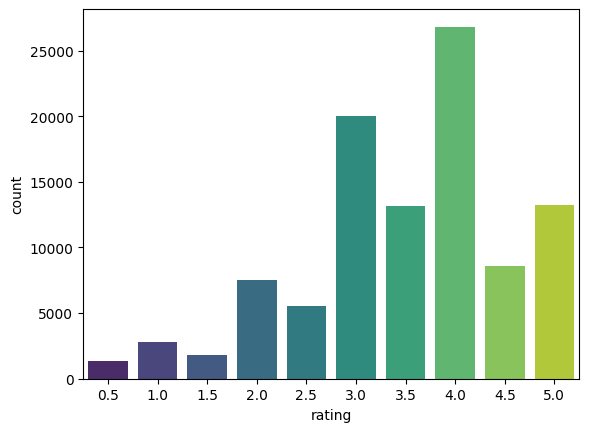

In [28]:
sns.countplot(x='rating', data=ratings, palette='viridis')


In [22]:
movie_titles = dict(zip(movies['movieId'], movies['title']))

In [31]:
movie_stats = ratings.groupby('movieId')[['rating']].agg(['count','mean'])
movie_stats.columns = movie_stats.columns.droplevel()

C = movie_stats['count'].mean()
m = movie_stats['mean'].mean()

def bayesian_avg(ratings):
  bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
  return bayesian_avg

bayesian_avg_ratings = ratings.groupby('movieId')['rating'].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ['movieId', 'bayesian_avg']

movie_stats = movie_stats.merge(bayesian_avg_ratings, on='movieId')
movie_stats.describe()

,movieId,count,mean,bayesian_avg
count,9724.000000,9724.000000,9724.000000,9724.000000
mean,42245.024373,10.369807,3.262448,3.285871
std,52191.137320,22.401005,0.869874,0.227598
min,1.000000,1.000000,0.500000,2.190377
25%,3245.500000,1.000000,2.800000,3.151413
50%,7300.000000,3.000000,3.416667,3.283341
75%,76739.250000,9.000000,3.911765,3.390547
max,193609.000000,329.000000,5.000000,4.392070


In [32]:
from scipy.sparse import csr_matrix

In [59]:
def create_sparse(df):
  M = df['userId'].nunique()
  N = df['movieId'].nunique()
  user_mapper = dict(zip(np.unique(df['userId']), list(range(M))))
  movie_mapper = dict(zip(np.unique(df['movieId']), list(range(N))))
  user_inv_mapper = dict(zip(list(range(M)), np.unique(df['userId'])))
  movie_inv_mapper = dict(zip(list(range(N)), np.unique(df['movieId'])))
  user_index = [user_mapper[i] for i in df['userId']]
  item_index = [movie_mapper[i] for i in df['movieId']]
  X = csr_matrix((df['rating'], (user_index, item_index)), shape=(M,N))

  return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper


In [57]:
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz #scipy.sparse.csr_matrix.nnz no of stored values, including explicit 0
sparsity = n_ratings/n_total
sparsity_p = round("sparsity*100,2)}%")
print(f"Matrix sparsity: {sparsity_p}%”)
n_ratings_per_user = X.getnnz(axis=1)

SyntaxError: unterminated string literal (detected at line 5) (<ipython-input-57-7414dfec7f7c>, line 5)

In [51]:
from sklearn.neighbors import NearestNeighbors
def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine’):
X = X.T
neighbour_ids = []
movie_ind = movie_mapper[movie_id]
movie_vec = X[movie_ind]
if isinstance(movie_vec, (np.ndarray)):
  movie_vec = movie_vec.reshape(1,-1)
  kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
  kNN.fit(X)
neighbour = kNN.kneighbors(movie_vec, return_distance=False)
for i in range(0,k):
  n = neighbour.item(i)
  neighbour_ids.append(movie_inv_mapper[n])
neighbour_ids.pop(0)
return neighbour_ids

SyntaxError: unterminated string literal (detected at line 2) (<ipython-input-51-7f8dbc1e7d40>, line 2)